In [1]:
%matplotlib inline


# OpenStreetMap with OSMnx

This example shows how to use OSMnx to download and model a street network
from OpenStreetMap, visualize centrality, and save the graph as a shapefile,
a GeoPackage, or GraphML.

OSMnx is a Python package to retrieve, model, analyze, and visualize
OpenStreetMap street networks as NetworkX MultiDiGraph objects. It can also
retrieve any other spatial data from OSM as geopandas GeoDataFrames. See
https://osmnx.readthedocs.io/ for OSMnx documentation and usage.


In [8]:
import json

Z = json.load(open("zameldowania_stale_2022_krk.geojson"))

In [35]:
from pyproj import Transformer

transformer = Transformer.from_crs(Z["crs"]["properties"]["name"], "EPSG:4326")

In [36]:
ZF = Z["features"]

In [37]:
len(ZF)

1480

In [62]:
def parse_feature(f):
    center_lat = 0
    center_long = 0
    cnt = 0
    for x, y in f["geometry"]["coordinates"][0]:
        lat, long = transformer.transform(y, x)
        # simple avg
        center_lat += lat
        center_long += long
        cnt += 1

    center_lat /= cnt
    center_long /= cnt

    return {
        "lat": center_lat,
        "long": center_long,
        "people": f["properties"]["r_ogolem"],
    }


lat_long_people = [parse_feature(zf) for zf in ZF]

In [202]:
import networkx as nx
import osmnx as ox

ox.config(use_cache=True, log_console=True)

# download street network data from OSM and construct a MultiDiGraph model
G = ox.graph_from_point(
    (50.061541, 19.938039),
    dist=5000,
    network_type="drive",
    simplify=True,
    custom_filter='["highway"~"primary|secondary|tertiary"]',
)

G_orig = G

G = ox.project_graph(G)
G = ox.simplification.consolidate_intersections(
    G, tolerance=60, rebuild_graph=True, dead_ends=False, reconnect_edges=True
)

# impute edge (driving) speeds and calculate edge traversal times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

G = G.to_undirected()

/home/norbert/.local/lib/python3.11/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [215]:
for i in G.nodes:
    for j in G.nodes:
        if j in G[i]:
            print(G[i][j][0]["travel_time"])

(0, 19, 0)
(0, 117, 0)
(0, 95, 0)
(0, 136, 0)
(1, 2, 0)
(1, 3, 0)
(2, 4, 0)
(2, 74, 0)
(3, 157, 0)
(4, 5, 0)
(4, 105, 0)
(5, 202, 0)
(5, 77, 0)
(5, 73, 0)
(6, 7, 0)
(6, 69, 0)
(6, 66, 0)
(6, 68, 0)
(7, 67, 0)
(7, 65, 0)
(8, 48, 0)
(8, 67, 0)
(8, 70, 0)
(8, 72, 0)
(9, 10, 0)
(9, 11, 0)
(9, 25, 0)
(9, 75, 0)
(9, 12, 0)
(9, 24, 0)
(9, 77, 0)
(9, 199, 0)
(10, 22, 0)
(10, 199, 0)
(11, 12, 0)
(11, 13, 0)
(12, 63, 0)
(12, 158, 0)
(13, 118, 0)
(13, 63, 0)
(14, 15, 0)
(14, 140, 0)
(14, 135, 0)
(14, 136, 0)
(14, 208, 0)
(15, 201, 0)
(16, 17, 0)
(16, 18, 0)
(17, 201, 0)
(18, 19, 0)
(20, 21, 0)
(20, 128, 0)
(20, 166, 0)
(20, 126, 0)
(20, 131, 0)
(21, 66, 0)
(21, 86, 0)
(22, 159, 0)
(22, 23, 0)
(22, 24, 0)
(22, 160, 0)
(22, 170, 0)
(23, 188, 0)
(23, 101, 0)
(23, 187, 0)
(23, 177, 0)
(24, 25, 0)
(25, 77, 0)
(26, 27, 0)
(26, 82, 0)
(27, 191, 0)
(27, 83, 0)
(28, 29, 0)
(28, 30, 0)
(28, 31, 0)
(29, 112, 0)
(30, 138, 0)
(30, 189, 0)
(31, 112, 0)
(31, 154, 0)
(31, 123, 0)
(31, 137, 0)
(32, 33, 0)
(32, 16

In [201]:
import math


def f(d):
    return 10 * math.exp(-100 * d)


points = []
D = []
for idx in G.nodes:
    node = G.nodes[idx]
    if "lat" in node and "lon" in node:
        lat, long = node["lat"], node["lon"]
    else:
        lat = 0
        long = 0
        cnt = 0
        for orig_idx in eval(node["osmid_original"]):
            orig_node = G_orig.nodes[orig_idx]
            lat += orig_node["y"]
            long += orig_node["x"]
            cnt += 1
        lat /= cnt
        long /= cnt

    #     print(f"{lat:20.6f} {long:20.6f}")

    S = 0
    for llp in lat_long_people:
        d2 = (lat - llp["lat"]) ** 2 + (long - llp["long"]) ** 2
        d = math.sqrt(d2)

        S += llp["people"] * f(d)

        D.append(d)
    points.append(S)

#     else:
#         points.append(-1)

# points
# min(D), max(D)

(217, 217)

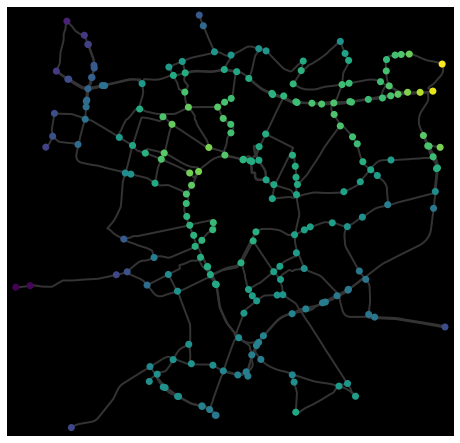

In [199]:
fig, ax = ox.plot_graph(
    G,
    bgcolor="k",
    node_color=points,
    node_size=50,
    edge_linewidth=2,
    edge_color="#333333",
)

# save graph to shapefile, geopackage, or graphml
# ox.save_graph_shapefile(G, filepath="./graph_shapefile/")
# ox.save_graph_geopackage(G, filepath="./graph.gpkg")
# ox.save_graphml(G, filepath="./graph.graphml")